In [1]:
from dataset import JanusDataset
import torch
from sklearn.model_selection import train_test_split


In [2]:
filename = "data/fulldataset.csv"
janus_data = JanusDataset(filename, 10, torch.device("cpu"))
dataset, discrete_columns = janus_data.prepare_janus_dataset()
fit, val, test = janus_data.split(test_size=0.20, random_state=42)

transformer = janus_data.transform_janus_dataset(fit[0])

In [3]:
tfit = transformer.transform(fit[0])
tval = transformer.transform(val[0])
ttest = transformer.transform(test[0])

In [4]:
disc_cols = [
    (col, len(dataset[col].unique()))
    for col in discrete_columns
]

In [5]:
discrete_columns_indx = [
    dataset.columns.get_loc(col)
    for col in discrete_columns
]

In [ ]:
from src.pythae.models import VAE, VAEConfig
from src.pythae.trainers import BaseTrainer
from src.pythae.pipelines.training import TrainingPipeline
from src.pythae.trainers import BaseTrainerConfig

from nn_benchmark import Encoder, Decoder
encoder = Encoder(transformer.output_dimensions, (10,), 10)
decoder = Decoder(10, (10,), transformer.output_dimensions)

net = VAE(
    VAEConfig((transformer.output_dimensions,), 20, False, False),
    encoder=encoder,
    decoder=decoder,
    categorical_columns=discrete_columns_indx,
    output_info = transformer.output_info_list,
)


config = BaseTrainerConfig(
    output_dir='my_model',
    learning_rate=1e-4,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_epochs=10, # Change this to train the model a bit more
)
pipeline = TrainingPipeline(training_config=config, model=net)
pipeline(tfit, tval)

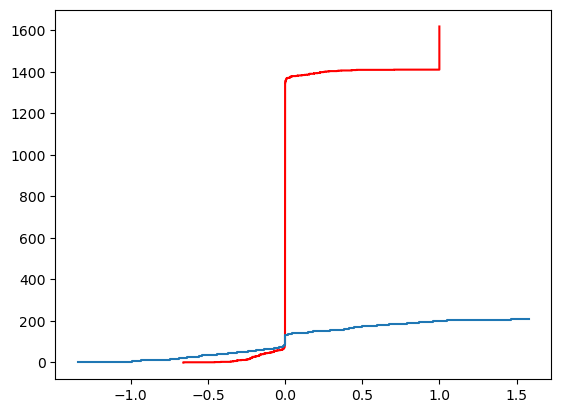

In [22]:
# z = torch.randn((1, 10), device=torch.device("cuda"))
# recon_x = net.decoder(z).reconstruction

x = torch.from_numpy(ttest[0].astype("float32")).unsqueeze(0).cuda()
recon_x = net({"data": x}).recon_x.detach().cpu().numpy()
recon_x = transformer.inverse_transform(recon_x)
x = x.cpu()

import numpy as np
sorted_x = np.sort(x)
sorted_recon_x = np.sort(recon_x)

import matplotlib.pyplot as plt
plt.step(sorted_x.squeeze(0), torch.arange(0, sorted_x.shape[-1], 1), c="r")
plt.step(sorted_recon_x.squeeze(0), torch.arange(0, sorted_recon_x.shape[-1], 1))

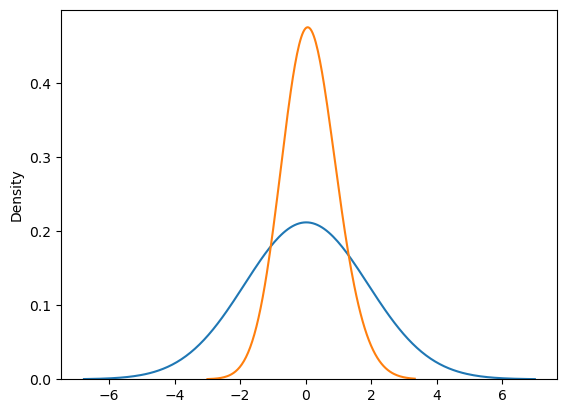

In [23]:
import seaborn as sns
sns.kdeplot(recon_x.squeeze(0), bw_adjust=10)
sns.kdeplot(x.squeeze(0), bw_adjust=10)
plt.show()

In [82]:
from ctgan import TVAE

X = dataset.iloc[:,:-2]

model = TVAE(
    128,
    (128, 128),
    (128, 128),
    batch_size=64,
    epochs=10,
    loss_factor=1.0,
)

model.fit(X, discrete_columns)

In [83]:
import pandas as pd
real = pd.DataFrame(test[0], columns=X.columns)
transformed_real = model.transformer.transform(real)

In [84]:
mu, std, logvar = model.encoder(torch.from_numpy(transformed_real.astype("float32")).cuda())
z = mu + std*torch.randn_like(std)
recon_x, scale = model.decoder(z)
recon_x = recon_x.detach().cpu().numpy()
recon_x = model.transformer.inverse_transform(recon_x, scale.detach().cpu().numpy())


<Axes: xlabel='data_002', ylabel='Proportion'>

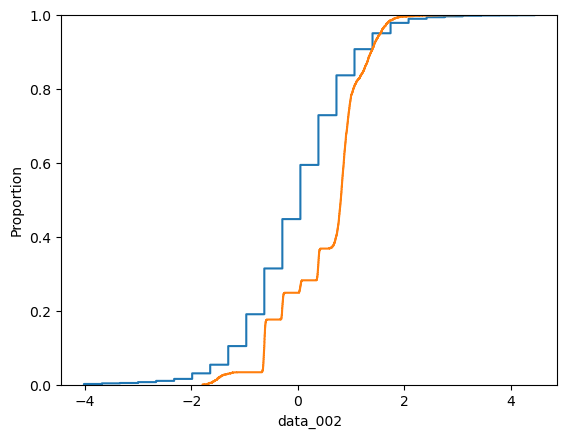

In [85]:
sns.ecdfplot(data=real, x="data_002")
sns.ecdfplot(data=recon_x, x="data_002")

In [92]:
from sdmetrics.reports import utils
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(real)
fig = utils.get_column_plot(
    real_data=real,
    synthetic_data=recon_x,
    column_name='data_158',
    metadata=metadata.to_dict(),
)

fig.show()

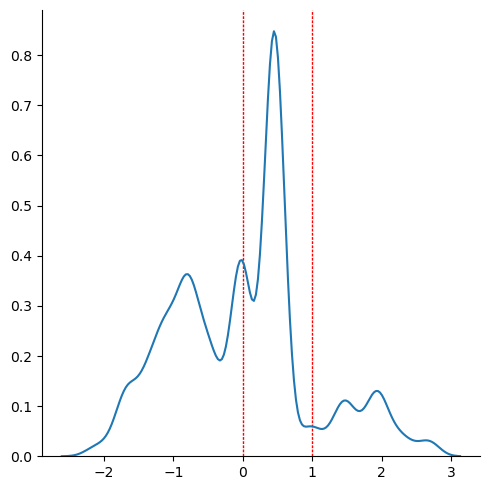

In [155]:
from sklearn import mixture

import warnings
warnings.filterwarnings("ignore")

# sns.set_context("science", font_scale=1.5, rc={"lines.linewidth": 2.5})

# import scienceplots
plt.style.use("default")

gm = mixture.BayesianGaussianMixture(n_components=5)
gm.fit(dataset["data_158"].values.astype("float32").reshape(-1, 1))


# dataset["data_158"].plot.density()

# g = sns.displot(dataset, x="data_158", kind="kde")
# for x in gm.means_:
#     g.map(plt.axvline, x=x, color="red", dashes=(2, 1), zorder=0, linewidth=1)


BayesianGaussianMixture(n_components=5)

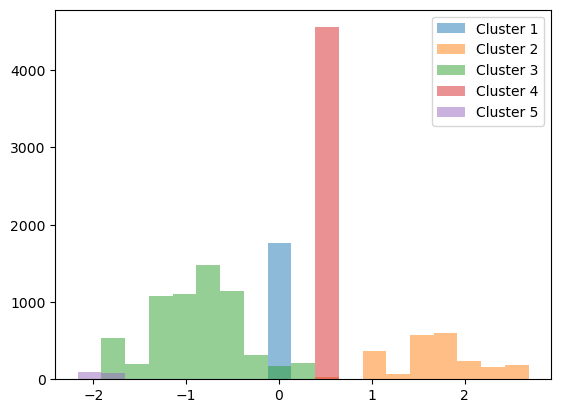

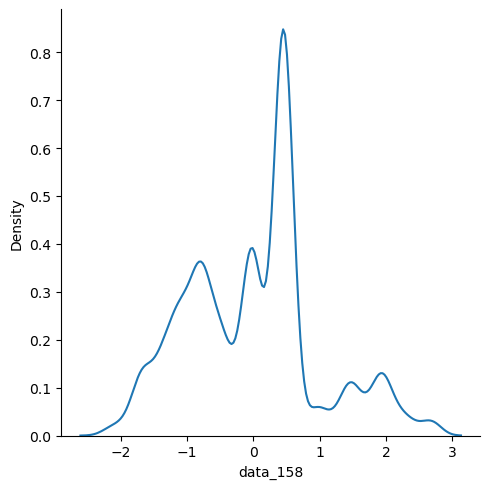

In [191]:
z = dataset["data_158"].values.astype("float32").reshape(-1, 1)
cluster_id = gm.predict(z)

fig, ax = plt.subplots()
bins = np.linspace(z.min(), z.max(), 20)
for ii in np.unique(cluster_id):
    subset = z[cluster_id==ii]
    ax.hist(subset, bins=bins, alpha=0.5, label=f"Cluster {ii+1}")
sns.displot(dataset, x="data_158", kind="kde", ax=ax)
ax.legend()
plt.show()